==============================================================================================
# Practicum 5

==============================================================================================

## Delivery

Your overall grading will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented exhaustively and in **English**. 

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Answers to questions also need to be in **English**.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- The deliverable of both parts must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook (upload the ones that were not provided)
    
- It is required that your code can be run by us without need of any modification and without getting any errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please refrain from utilizing resources like ChatGPT to complete this lab assignment.


**Deadline: December 22th, 23:00 h**

==============================================================================================

This lab covers the following topics: 
* Gaussian filters
* Descriptors based on texture
* Distance between images and similarity search
* Face detection using:
    * Haar-like features
    * Adaboost
    * PCA



==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



### Imports

In [1]:
%matplotlib inline
# GENERAL ONES FOR IMAGE ANALYSIS
import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from time import time
### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

# Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images/filter_bank.png">


We import Leung-Malik filters as follows:

In [2]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()
# NOTE: If this does not work, go to appendix for function code

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


### Plotting all filters

Plot the created filters as images similar to the figure above.

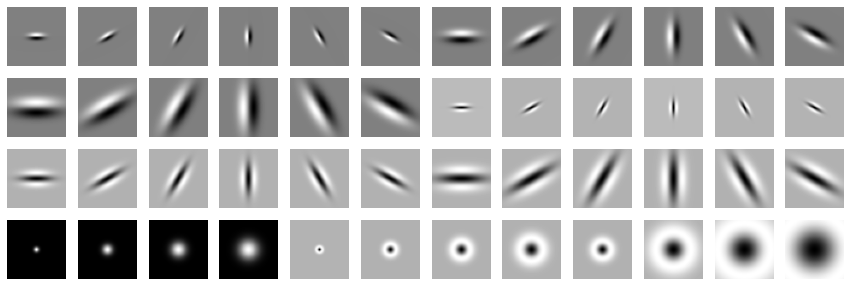

In [3]:
# Create a subplot with 4 rows and 12 columns, and set the figure size
fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,5))

# Initialize a counter variable
c = 0

# Iterate over the rows
for i in range(4):
    # Iterate over the columns
    for j in range(12):
        # Display the filter image in the current subplot
        ax[i,j].imshow(filter_bank[:,:,c], cmap = 'gray')
        ax[i,j].axis("off")
        # Increment the counter
        c += 1

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

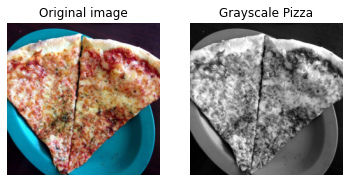

In [4]:
# Your solution here
import skimage.color as color

#Reading the image, resizing and converting to grayscale
pizza = io.imread('./images/pizza.jpg')
pizza = resize(pizza, (240, 240))
pizza_gray = color.rgb2gray(pizza)


#Plotting the original image and the grayscale image
fig, axs = plt.subplots(1, 2)
ax = axs[0]
ax.imshow(pizza)
ax.set_title('Original image')
ax.axis('off')

ax = axs[1]
ax.imshow(pizza_gray, cmap='gray')
ax.set_title('Grayscale Pizza')
ax.axis('off')

plt.show()

**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the **mean of the absolute value of the convolved image** by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [5]:
# Your solution here

from scipy.ndimage import convolve

def get_image_features(image, filter_bank, n_filters):
    # Initialize an array to store the features, one for each filter
    features = np.zeros(n_filters)
    
    for i in range(n_filters):
        #For each filer we convolve the image with it and calculate the mean of the absolute values
        features[i] = np.mean(abs(convolve(image, filter_bank[:,:,i])))
    
    return features

In [6]:
## Try the function
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
print(im_features)

[0.01601815 0.01451256 0.01425982 0.01591883 0.01727063]



**1.3** (Optional) Try ``get_image_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [7]:
# Choose the dog image
image_path = './images/dog.jpg'

# Read and resize the image
image = io.imread(image_path)
image = resize(image, (240, 240))
image_gray = color.rgb2gray(image)

# Modify the number of filters
n_filters = 10

# Call the get_image_features() function
im_features = get_image_features(image_gray, filter_bank, n_filters)

# Print the feature vector
print(im_features)

[0.00677373 0.0066682  0.00774297 0.00897879 0.00877699 0.00778947
 0.00473181 0.00475119 0.00536269 0.00620741]


### Visualizing features

**1.4** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that receives the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [8]:
# Your solution here

def visualize_features(im,  filter_bank, n_filters=5):
    # List of filtered images created applying each filter in the filter bank to the input image
    features = [abs(convolve(im, filter_bank[:,:,i])) for i in range(n_filters)]
    
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,5))
    c = 0
    for i in range(2):
        #For each filter...
        for j in range(n_filters):
            #Display in the first row display the filtered image
            if i<1:
                ax[i,j].imshow(features[c], cmap = 'gray')
                ax[i,j].axis("off")
                c += 1
            else:
                # Display the filter in the second row
                ax[i,j].imshow(filter_bank[:,:,c-n_filters], cmap = 'gray')
                ax[i,j].axis("off")
                c += 1
    plt.show()

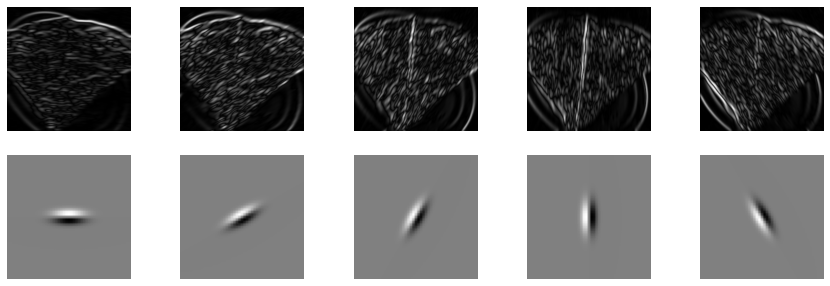

In [9]:
## Try the function
visualize_features(pizza_gray, filter_bank)

**1.5** (Optional) Try ``visualize_features()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

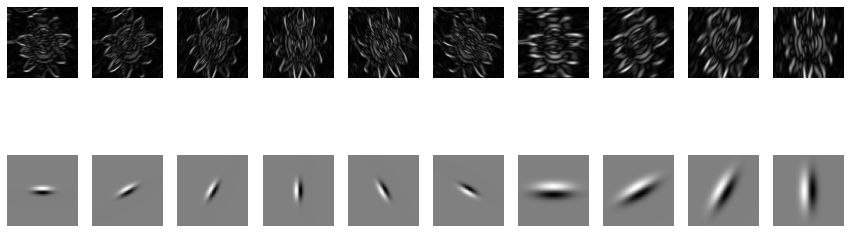

In [10]:
# Your solution here

# Choose the flower image
image_path = './images/flower.jpg'

# Read and resize the image
image = io.imread(image_path)
image = resize(image, (240, 240))
image_gray = color.rgb2gray(image)

# Modify the number of filters
n_filters = 10

# Call the visualize_features() function
visualize_features(image_gray, filter_bank, n_filters)

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [11]:
# Your solution here
#Loading the images
pizza_images = io.ImageCollection("./images/pizza/*.jpg")
flowers_images = io.ImageCollection("./images/flowers/*.jpg")
pets_images = io.ImageCollection("./images/pets/*.jpg")

In [12]:
#Resizing the images
pizza_images = [resize(image, (240,240)) for image in pizza_images]
flowers_images = [resize(image, (240,240)) for image in flowers_images]
pets_images = [resize(image, (240,240)) for image in pets_images]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

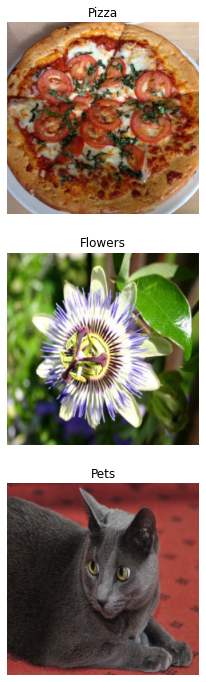

In [13]:
# Your solution here
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,12))

#Plotting the three images
ax = axs[0]
ax.imshow(pizza_images[0])
ax.set_title('Pizza')
ax.axis('off')

ax = axs[1]
ax.imshow(flowers_images[0])
ax.set_title('Flowers')
ax.axis('off')

ax = axs[2]
ax.imshow(pets_images[0])
ax.set_title('Pets')
ax.axis('off')

plt.show()

How many images there are in **each** directory?

In [14]:
# Your solution here
print(f"Number of images in pizza_images: {len(pizza_images)}")
print(f"Number of images in flowers_images: {len(flowers_images)}")
print(f"Number of images in pets_images: {len(pets_images)}")

Number of images in pizza_images: 30
Number of images in flowers_images: 29
Number of images in pets_images: 29


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `get_image_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [15]:
# Your solution here
def get_dataset_features(all_images, filter_bank, n_filters=6):
    #Initialize array to store the features for each image in the dataset
    dataset = np.zeros((len(all_images), n_filters))
    
    #For each image...
    for i in range(len(all_images)):
        #Convert the image to grayscale
        grayscale_image = color.rgb2gray(all_images[i])
        #Extract the features of the image and store it in the created array
        dataset[i] = get_image_features(grayscale_image, filter_bank, n_filters)
    return dataset

In [16]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors=get_dataset_features(all_images, filter_bank, 5)

Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[2]*), image #33, and image #53, directly from the vector

In [17]:
# Your solution here
print(f"Shape of the feature_vectors: {feature_vectors.shape}")
print(f"Feature of image#3: {feature_vectors[3]}")
print(f"Feature of image#33: {feature_vectors[33]}")
print(f"Feature of image#53: {feature_vectors[53]}")

Shape of the feature_vectors: (88, 5)
Feature of image#3: [0.01562379 0.01424202 0.01176938 0.01036031 0.01115835]
Feature of image#33: [0.00908792 0.00943673 0.01047559 0.01103026 0.01043528]
Feature of image#53: [0.01124157 0.01212887 0.01380434 0.0143961  0.01319082]


### Visualizing the features of an image

**2.3** Define a function `visualize_features_imgs(im_index, feature_vector)` that given n different images, plots their features. Use different colors to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

<img src="./images/example_plot_features.jpg" >


In [18]:
# Your solution here
def visualize_features_imgs(im_index, feature_vector):
    #List of colors for the points of the plot
    rgb = ['r','g','b']
    index = 0
    #For each image...
    for i in range(len(im_index)):
        #For each feature of the image...
        for j in range(len(feature_vector[im_index[i]])):
            #Plot it 
            punt = plt.scatter(index+j, feature_vector[i][j], c=rgb[i])
        index += j+1
    plt.title("Features")
    plt.show()

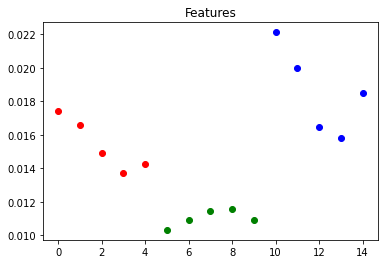

In [19]:
## Try the function
visualize_features_imgs( [2,32,52] , feature_vectors)


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

In [20]:
# Your solution here
def retrieve_images(im_features, feature_vectors, k=5):
    vector_distances = []
    distance = []
    #For each feature vector...
    for feature in feature_vectors:
        # Calculate the Euclidean distance between the input image's features and the feature vector
        d = np.linalg.norm(im_features - feature)
        distance.append(d)
    #Sort the distances in ascending order and select the k smallest distances
    index = sorted(range(len(distance)), key = lambda sub: distance[sub])[:k]
    #Append the corresponding smallest distances
    for i in index:
        vector_distances.append(distance[i])

    # Return the indices and the distances of the k most similar images
    return index, vector_distances

Try your function using ``/images/pizza.jpg``.

In [21]:
# Try your function
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)

closest, distances = retrieve_images(im_features, feature_vectors, k=5)
print(closest, distances)

[5, 35, 87, 11, 86] [0.0, 0.002406726965622973, 0.002890805397386681, 0.0030828541280967085, 0.003350707627978659]


**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


In [22]:
# Your solution here
def show_closest_images(all_images, closest, distances) :
    fig, axs = plt.subplots(1, len(closest), figsize=(20, 20))
    for i in range(len(closest)):
        ax = axs[i]
        ax.imshow(all_images[int(closest[i])])
        ax.set_title(f"Distance: {distances[i]:.5f}")
        ax.axis('off')

[5, 35, 87, 11, 86]
[0.0, 0.002406726965622973, 0.002890805397386681, 0.0030828541280967085, 0.003350707627978659]


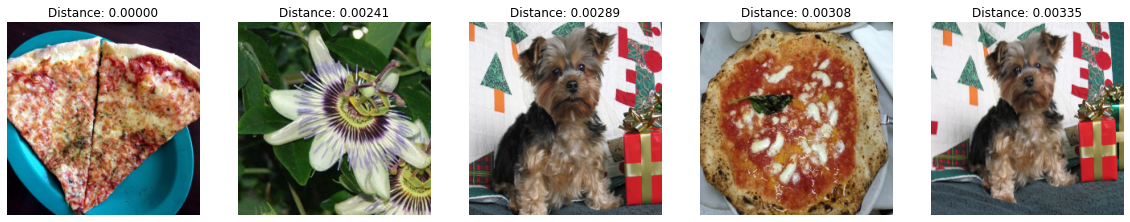

In [23]:
show_closest_images(all_images, closest, distances)
print(closest)
print(distances)

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [24]:
# Your solution here
class_labels = np.concatenate((np.zeros(30), np.ones(29),  2 * np.ones(29))).reshape(88,1)
def accuracy(feature_vectors, class_labels, im_features, class_im,  k=5):
    
    similar = 0.0
    total = 0.0

    #Retrieve the k most similar images
    imgs, dist = retrieve_images(im_features, feature_vectors, k)

    #For each retrieved image 
    for img, distance in zip(imgs, dist):
        # Skip images with a distance of 0.0 (it's the same image)
        if distance == 0.0:
            continue

        #Check if the image belongs to the same class 
        if class_labels[img] == class_im:
            similar += 1  
        total += 1  # Increment total for each non-skipped image

    # Calculate and return the accuracy as a percentage
    return (similar / total) * 100 if total > 0 else 0

In [25]:
print("acc:", accuracy(feature_vectors, class_labels, im_features, 0 , k=5))

acc: 25.0


Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

## Answer to the question

> Given k=10, we updated the __im_features__ and __feature_vectors__ so that we will have 10 images for study. As we can see from the output below, we have 10 images but the first one is the query image, so we will count it as 9 images. And if we check the rest of the images, we have 4 pizzas (same class as the query image), so if we do 4/9 we get an accuracy of 44.44%, which match the results.

acc: 44.44444444444444


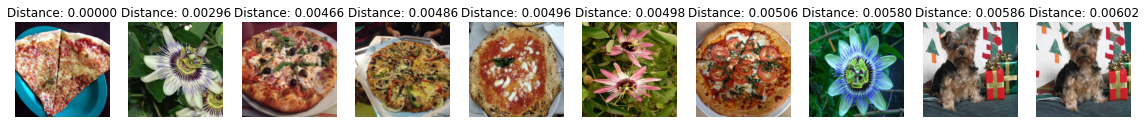

In [26]:
n_filters = 10
im_features = get_image_features(pizza_gray, filter_bank, n_filters)

feature_vectors=get_dataset_features(all_images, filter_bank, 10)

closest, distances = retrieve_images(im_features, feature_vectors, k=10)

show_closest_images(all_images, closest, distances)

print("acc:", accuracy(feature_vectors, class_labels, im_features, 0 , k=10))

### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

* Plot the new features of an image, using `visualize_features_imgs()`. 
* Then, show the 5 closest images (use show_closest_images) from `im_features`
* Compute the accuracy. 

**Is there any difference? Do we obtain the same images than previously?**

## Answer to the question

> We can affirm that after showing the closest images and printing the accuracy that we obtain the same images. It is true though that after normalizing the features between [0,1], it is possible that in some cases we may not obtain the same images as previously during the image retrieval process. This is because normalization can alter the relative distances between feature vectors, which in turn can change which images are considered closest to our query image.

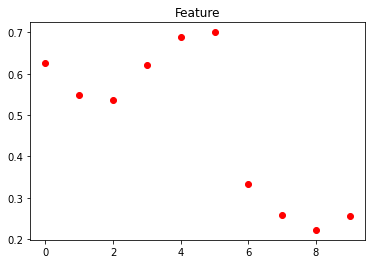

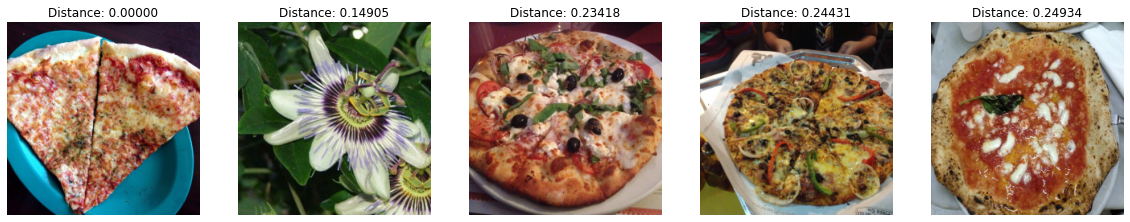

In [27]:
# Your solution here
def visualize_features_imgs(feature_vector):
    #For each feature_vector plot each feature value
    for i in range(len(feature_vector)):
        punt = plt.scatter(i,feature_vector[i], c="r")
    plt.title("Feature")
    plt.show()

# Normalize the feature vectors and the image's features to be within the range [0, 1]
# subtracting the minimum value of the feature vectors and then dividing by the range
new_feature_vectors = (feature_vectors-np.min(feature_vectors))/(np.max(feature_vectors)-np.min(feature_vectors))
new_im_features = (im_features-np.min(feature_vectors))/(np.max(feature_vectors)-np.min(feature_vectors))

visualize_features_imgs(new_im_features)

# Retrieve the indices and distances of the 5 closest images to the specified image
closest, distances = retrieve_images( new_im_features, new_feature_vectors, k=5)
show_closest_images(all_images, closest, distances)

In [28]:
print("acc:", accuracy(new_feature_vectors, class_labels, new_im_features, 0 , k=5))

acc: 75.0


# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, similar to what it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** Consider each bin from each channel as a feature, create a vector with all the features together. 

In [29]:
# Your solution here
from skimage import *
from skimage import img_as_float

%matplotlib inline
def lm_features_rgb(rgb_image, n_bins=12):
    #Convert the image to float format
    image_float = img_as_float(rgb_image)
    
    #Compute the histogram for each color channel
    red_channel, bin_centers = exposure.histogram(image_float[:,:,0], nbins = n_bins)
    green_channel, bin_centers = exposure.histogram(image_float[:,:,1], nbins = n_bins)
    blue_channel, bin_centers = exposure.histogram(image_float[:,:,2], nbins = n_bins)
    
    # Add all the channels to a single array and displat the plot
    data = np.array(red_channel+green_channel+blue_channel)
    plt.plot(data, "")
    plt.show()
    return data

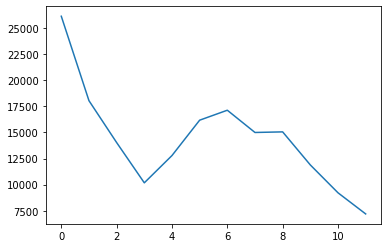

12


In [30]:
# Try your function
lm_rgb_features = lm_features_rgb(pizza)
print(len(lm_rgb_features))


## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in  `all_images` and save them in `lm_dataset_features`.

In [31]:
%%time 
'''
Solution
'''
def get_datapoints(all_images, n_bins=12):
    # Use joblib's Parallel and delayed functions to enable parallel processing to have a better performace
    # n_jobs=2 specifies that two parallel jobs should be run
    # For each image in all_images, lm_features_rgb function is called with n_bins as argument
    lm_dataset_features=[joblib.Parallel(n_jobs=2)(delayed(lm_features_rgb)(img, n_bins) for img in all_images)]
    return lm_dataset_features

CPU times: user 1 µs, sys: 12 µs, total: 13 µs
Wall time: 4.05 µs


In [32]:
import joblib
lm_dataset_features = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)Figure(640x480)

Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(6

## Compute the accuracy of the method using `lm_features_rgb`

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Show the 4 closest images to the query images in the `lm_rgb` space with the function built before.

Is the accuracy higher? Please, comment the results.

## Answer to the question

> We can see that the accuracy is significantly higher (now we are in a 75%).

> Using RGB (Red, Green, Blue) color information for image feature extraction often leads to higher accuracy in image retrieval tasks because:

    - Color Distinctiveness: Colors are highly distinctive and easily distinguishable, making them effective for differentiating between images.

    - Robustness: RGB features are less affected by changes in shape, size, and orientation, focusing instead on color which is a strong visual cue.

    - Computational Efficiency: Color-based features are simpler and faster to compute compared to more complex features like texture or shape.

    - Alignment with Human Perception: The RGB model aligns well with human vision, making the retrieval results more intuitive and relevant.

    - Quantifiable Comparisons: RGB values provide a measurable way to compare the similarity between images.

> In summary, RGB color features are effective for image retrieval due to their distinctiveness, robustness to variations, computational efficiency, alignment with human perception, and their quantifiable nature for comparing images.

acc: 75.0


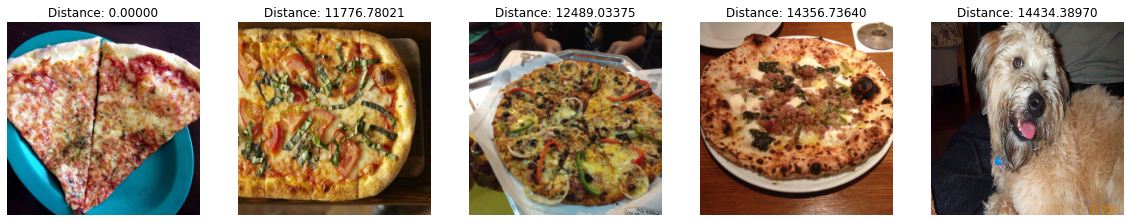

In [33]:
# Your solution here
print("acc:", accuracy(lm_dataset_features, class_labels, lm_rgb_features, 0, k=5))
closest, distances = retrieve_images( lm_rgb_features, lm_dataset_features, k=5)
show_closest_images(all_images, closest, distances)

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features.

### 6. Building integral image and Haar-like features

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="images/integral_image.PNG" width=250, height=2500>

An example :

<img src="images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

## Answer to the question

> The additional row and column of zeros in an integral image, especially for computing Haar features, serve a dual purpose of simplifying computations and efficiently handling boundary conditions:

    - Boundary Handling: When computing sums over rectangular regions in the image, the extra zeros prevent the need for special handling at the borders of the image. Without these zeros, calculations that reach the edges would require additional logic to avoid accessing pixels outside the image boundaries.

    - Simplification of Calculations: The integral image is a tool for quickly calculating the sum of pixel values within rectangular areas. By starting with a zeroed row and column, the process of calculating these sums becomes more straightforward. In an integral image, each point represents the sum of all pixels above and to the left, including itself. The zeros ensure that sums can be computed uniformly across the entire image, including at the edges, using a consistent formula.

    -Efficient Computation: With this setup, the integral image can be computed efficiently. The zeroed row and column mean that when iterating over the image to compute these sums, there's no need to check for edge cases (i.e., being at the first row or column), streamlining the computation process.

> In summary, these additional zeros are a practical solution to make the algorithm more robust and efficient, especially for features that interact with the image boundaries.

**6.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one. Refrain from using built-in functions that already do the integral, compute it yourself. 

In [34]:
#your solution
def to_integral_image(image):

    integral_image = np.zeros((image.shape[0] + 1, image.shape[1] + 1))

  # Loop through the image and compute the integral image
    for x in range(1, image.shape[0] + 1):
        for y in range(1, image.shape[1] + 1):
            integral_image[x][y] = integral_image[x-1][y] + integral_image[x][y-1] - integral_image[x-1][y-1] + image[x-1][y-1]

    return integral_image

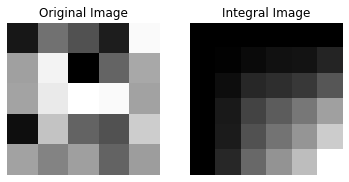

In [35]:
# Visualizing results on a random grayscale image
random_img = np.random.randint(255, size=(5, 5))
integral_img = to_integral_image(random_img)

fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.imshow(random_img, cmap="gray")
ax.axis("off")
ax.set_title("Original Image")

ax = axes[1]
ax.imshow(integral_img, cmap="gray")
ax.axis("off")
ax.set_title("Integral Image")

plt.show()

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [36]:
#your solution
print(random_img.sum())
print(integral_img[-1,-1])
random_img.sum() == integral_img[-1,-1]
print(random_img[0,:].sum())
print(integral_img[1,-1])
random_img[0,:].sum() == integral_img[1,-1]

3444
3444.0
502
502.0


True

**6.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

Here is an example (you don't have to pick this image, you can do it at random):
<img src="images/integral_image_example.jpg" width=500, height=250>

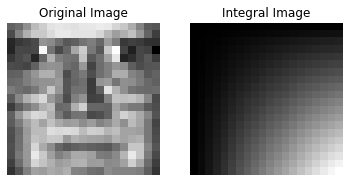

In [37]:
#your solution
original_img = io.imread("images/faces/face00039.png")
integral_img = to_integral_image(original_img)

fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.imshow(original_img, cmap="gray")
ax.axis("off")
ax.set_title("Original Image")

ax = axes[1]
ax.imshow(integral_img, cmap="gray")
ax.axis("off")
ax.set_title("Integral Image")

plt.show()

**6.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage (no need to provide a written answer here, just make sure you are obtain same results).

In [38]:
#your solution
mine = to_integral_image(original_img)
skim = integral_image(original_img)
print('to_integral_image: ',mine.sum(), ', sum of result matrix')
print('integral_image: ',skim.sum(),', sum of result matrix')

to_integral_image:  5283420.0 , sum of result matrix
integral_image:  5283420 , sum of result matrix


## Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**6.4** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [39]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [40]:
#your solution
def extract_feature_image(image, feature_type, feature_coord=None):
    # Convert the input image to its integral image representation
    iimage = integral_image(image)
    width, height = iimage.shape
    # Calculate and return the specified feature type from the integral image
    return haar_like_feature(iimage, 0,0, width, height, feature_type, feature_coord)

**6.5** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="images/image1.png" width=600, height=300>

*Note that there are multiple features and therefore your results might not exactly match this example, depending on your selection.*

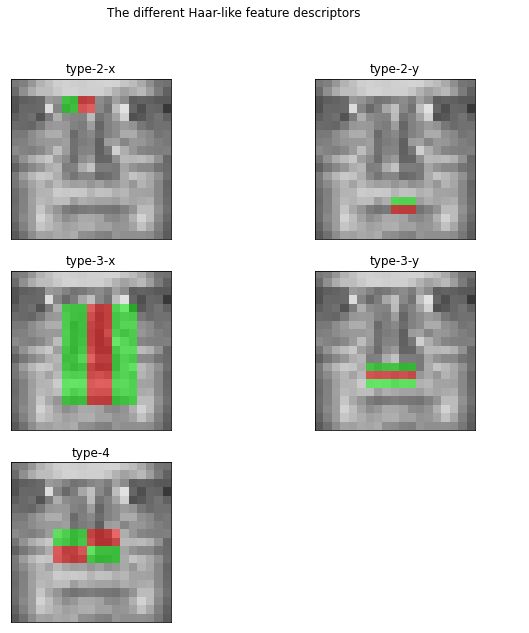

In [41]:
#your solution
def plotFeatures(image):
    fig, axs = plt.subplots(3, 2, figsize=(10,10))
    for ax, feat_t in zip(np.ravel(axs), feature_types):
         # Get the coordinates for the current Haar-like feature type based on the image's shape
        coord, _ = haar_like_feature_coord(image.shape[0], image.shape[1], feat_t)
        # Draw the Haar-like feature on the image for the given coordinates and feature type
        haar_feature = draw_haar_like_feature(image, 0, 0,image.shape[1],image.shape[0],coord,max_n_features =1)
        
        #Display the image and the Haar-like features 
        ax.imshow(haar_feature)
        ax.set_title(feat_t)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('The different Haar-like feature descriptors')
    plt.axis('off')
    plt.show()

plotFeatures(original_img)    

## 7 Face detection using an Adaboost

**7.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features (use the `built extract_feature_image` for this). 

Futhermore, build the class labels vector ``y`` with the label of all the images. Make sure both, images and labels are numpy array objects.

In [42]:
# Your solution here
pathFace = "images/faces/"  
pathNonFace = "images/nonfaces/"  
faces = [io.imread(pathFace + f) for f in os.listdir(pathFace)]
nonfaces = non_face_images = [io.imread(pathNonFace + f) for f in os.listdir(pathNonFace)]
# Combine face and non-face images into a single list
allImages =faces + nonfaces
allFeatures = []

#For each image 
for image in allImages:
    # Extract features from the image
    allFeatures.append(extract_feature_image(image, feature_types))
    
# Create a label array 'y', with 1's for face images and 0's for non-face images
y = np.array([1] * len(faces) + [0] * len(nonfaces))

**7.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Print the size of your images train and test set. 

In [43]:
# Your solution here
X_train, X_test, y_train, y_test = train_test_split(allFeatures, y,test_size=0.3,random_state=0,stratify=y)

# Print the sizes
print("Number of samples in X_train:", len(X_train))
print("Number of samples in X_test:", len(X_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 47
Number of samples in X_test: 21
Number of samples in y_train: 47
Number of samples in y_test: 21


**7.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

## Answer to the question

> AdaBoost (Adaptive Boosting) is a machine learning algorithm that combines multiple weak learners, typically simple decision trees, to form a strong classifier. It works by sequentially training weak learners, each focusing more on the instances that previous learners misclassified. The algorithm assigns more weight to these challenging instances and to more accurate learners. In the end, AdaBoost combines these learners through a weighted vote to make predictions, effectively improving the model's performance by focusing on difficult cases.

In [44]:
# Your solution here
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

**7.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. Make sure to use your test set for this. What are these methods doing?

## Answer to the question
1. predict Method:
    - prediction = ada_model.predict(X_test)
    - The predict method is used to make predictions on the test data. Here, we pass X_test (the features of our test dataset) to the predict method of our AdaBoost model.
    - The method returns an array of predicted labels for each instance in X_test. These are the model's best guesses for the class of each instance based on what it learned during training.

2. score Method:
    - score = ada_model.score(X_test, y_test)
    - The score method evaluates the accuracy of the model. We pass both X_test and y_test (the true labels of our test dataset) to this method.
    - It internally makes predictions for X_test and then compares these predictions against the true labels y_test. The method returns the accuracy, which is the proportion of correct predictions out of the total predictions made. This gives us a straightforward measure of how well our model is performing.

In summary, predict is used for generating predictions, and score provides a quick and easy way to evaluate the accuracy of those predictions against the true labels of our test data. Our code correctly uses both to assess the performance of your AdaBoost classifier.


In [45]:
# Your solution here
prediction = ada_model.predict(X_test)
score = ada_model.score(X_test, y_test)
print(prediction)
print(score)

[1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1]
0.9047619047619048


Change the parameter ``n_estimators`` and see what happens to the test set accuracy. Does the performance increased or decreased?

Try at least 3 different values of `n_estimators`

## Answer to the question

> Based on the results below, changing the n_estimators parameter in our AdaBoost classifier (testing with values of 10, 50, and 100) did not affect the test set accuracy. In all three cases, the accuracy remained the same at approximately 90.48%. This indicates that in our specific scenario, increasing the number of weak learners (estimators) in the AdaBoost algorithm did not lead to an improvement or decline in performance.

In [46]:
# Your solution here
# Different values for n_estimators
n_estimators_values = [10, 50, 100]

for n_estimators in n_estimators_values:
    # Create AdaBoost classifier with the current n_estimators value
    ada_model = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)

    # Train the model
    ada_model.fit(X_train, y_train)

    # Evaluate the model
    score = ada_model.score(X_test, y_test)
    print(f"Accuracy with n_estimators={n_estimators}: {score}")

Accuracy with n_estimators=10: 0.9047619047619048
Accuracy with n_estimators=50: 0.9047619047619048
Accuracy with n_estimators=100: 0.9047619047619048


**7.5 (Optional)** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features of the model. 

In [47]:
# Your solution here
def visualize10(image):
    coord, _ = haar_like_feature_coord(image.shape[0], image.shape[1], feature_types)
    sorted_index = np.argsort(ada_model.feature_importances_)[1:]
    fig, axes = plt.subplots(5, 2, figsize=(10,10))
    for idx, ax in enumerate(axes.ravel()):
        haar_feature = draw_haar_like_feature(image, 0, 0,image.shape[1],image.shape[0],[coord[sorted_index[idx]]])
        ax.imshow(haar_feature)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.axis('off')
    plt.show()

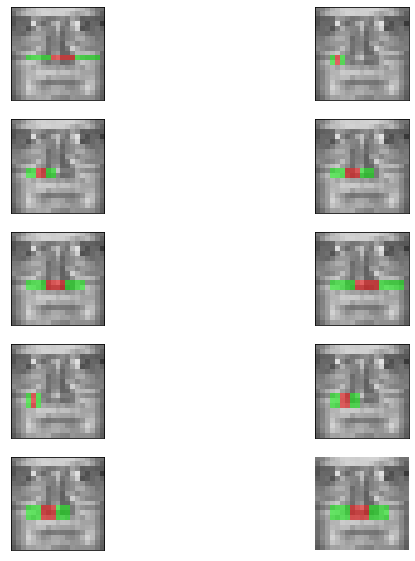

In [48]:
visualize10(original_img)

==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 8. Load and prepare data for PCA

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**8.1** Load the dataset, obtaining only those cases where there are, **at least, 100 images**. Check the final number of images, image shapes and labels of the images.

*Hint: There is a parameter to set the minimum number of faces per person to load in the dataset function*

In [49]:
# Your solution here
# Import the dataset of faces using the fetch_lfw_people function
# The dataset will only include people with at least 100 different pictures
faces_images = fetch_lfw_people(min_faces_per_person=100)

#Extract height and weight 
_, h, w = faces_images.images.shape
X = faces_images.data
y = faces_images.target
names = faces_images.target_names

print('Final number: ', X.shape[1])
print('Images shapes: ', h, ' hight ', w, ' width')
print('Labels: ', names)

Final number:  2914
Images shapes:  62  hight  47  width
Labels:  ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


**8.2** Plot an image frome each example, with its name as the title of the image.

<img src="images/example.png" width=500, height=500>

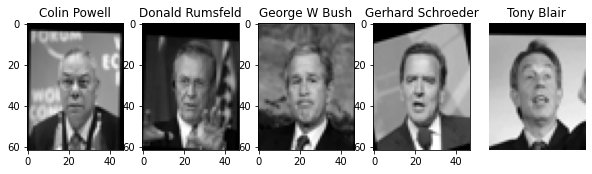

In [50]:
# Your solution here
images = faces_images.images
visited = []
i = 0
fig, axes = plt.subplots(1, 5, figsize=(10,10))
for ax in axes.flatten():
    face = (y == i)
    image = images[face][0]
    ax.imshow(image, cmap="gray")
    ax.set_title(names[i])
    i += 1

plt.axis('off')
plt.show()

**8.3** Divide the dataset into train and test set (0.7/0.3). Print the size of train and test image sets.

Hint: use the train_test_split function.

In [51]:
# Your solution here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7)

## Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**8.4** Create a PCA object, using the training set and 150 components. 

*Consider that PCA requires the data to be reshaped into 2 dimensions: number of observations x number of pixels*

In [52]:
# Your solution here
pca = PCA(n_components=150)
pca.fit(X_train)

PCA(n_components=150)

Plot the accumated variance of the components. 

**Hint:** Use `explained_variance_ratio_` to return the variance explained, plot this.

<img src="images/explained_variance_example.jpg" width=400, height=400>

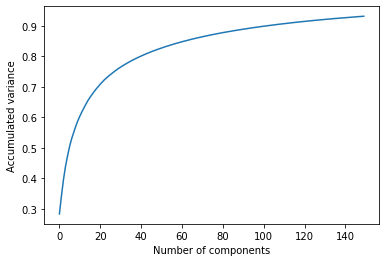

In [53]:
# Your solution here
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the accumulated variance
plt.plot(cumulative_variance)
plt.xlabel('Number of components')
plt.ylabel('Accumulated variance')
plt.show()

**8.5** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly


<img src="images/mean_face.jpg" width=200, height=200>


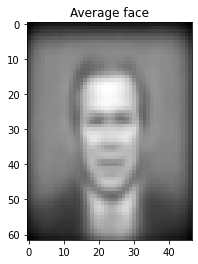

In [54]:
# Your solution here
mean_face = pca.mean_
mean_face = mean_face.reshape((h, w))

plt.imshow(mean_face, cmap='gray')
plt.title('Average face')
plt.show()

**8.6** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

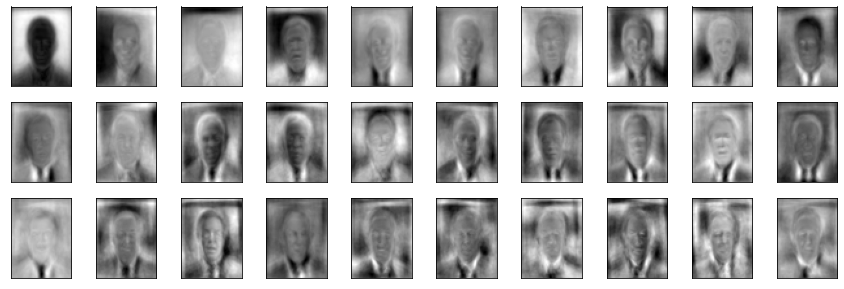

In [55]:
# Your solution here
# Extract the principal components from the PCA model and select the first 30 
principal_components = pca.components_

principal_components = principal_components[:30]
# Reshape each principal component into the original image dimensions
principal_components = [component.reshape((h, w)) for component in principal_components]

fig = plt.figure(figsize=(15, 5))

for i, component in enumerate(principal_components):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(component,cmap='gray')
plt.show()

**8.7** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="images/eigenfaces_image.PNG" width=300, height=300>

Example of output: 

<img src="images/recomposition_example.jpg" width=600, height=600>

In [56]:
# Your solution here
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

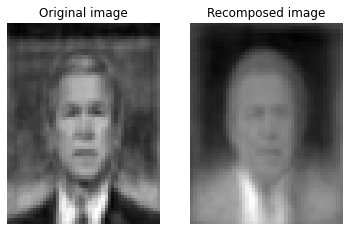

In [57]:
# Your solution here
# Target image
image = X_train_pca[0]
face = pca.inverse_transform(image).reshape((h, w))
# Weight image
weights = X_train_pca[0][:10]

# Sort the eigenvectors by their corresponding eigenvalues in decreasing order
indices = np.argsort(pca.explained_variance_)[::-1]
eigenfaces = pca.components_[indices]
# Select the first 10 eigenvectors
eigenfaces = eigenfaces[:10]
eigenfaces /= np.linalg.norm(eigenfaces)

# Use the weights and the first 10 eigenfaces to reconstruct the target image
result = np.dot(weights,eigenfaces)
result += pca.mean_/np.linalg.norm(pca.mean_)
result = result.reshape((h, w))

fig, axs = plt.subplots(1, 2)
ax = axs[0]
ax.imshow(face, cmap='gray')
ax.set_title('Original image')
ax.axis('off')

ax = axs[1]
ax.imshow(result, cmap='gray')
ax.set_title('Recomposed image')
ax.axis('off')

plt.show()

## Train a classifier

**8.8** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [58]:
# Your solution here
from time import time
t0 = time()

ada_model_pca = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_model_pca.fit(X_train_pca, y_train)

y_pred_pca = ada_model_pca.predict(X_test_pca)

score_pca = ada_model_pca.score(X_test_pca, y_test)

time = time() - t0
print(time)

0.8694231510162354


**8.9** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [59]:
print('The accuracy of the classifier in the PCA space is: ', score_pca)
print(classification_report(y_test, y_pred_pca, target_names=names))

The accuracy of the classifier in the PCA space is:  0.5701754385964912
                   precision    recall  f1-score   support

     Colin Powell       0.57      0.33      0.42        63
  Donald Rumsfeld       0.45      0.29      0.35        35
    George W Bush       0.60      0.83      0.70       163
Gerhard Schroeder       0.50      0.14      0.22        36
       Tony Blair       0.50      0.53      0.52        45

         accuracy                           0.57       342
        macro avg       0.52      0.42      0.44       342
     weighted avg       0.56      0.57      0.54       342



# Now without PCA

In [60]:
from time import time
t1 = time()
# Create an AdaBoostClassifier model with 100 estimators and a fixed random state for reproducibility
ada_model = AdaBoostClassifier(n_estimators=100, random_state=0)
# Fit the model to the training data
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)
score = ada_model.score(X_test, y_test)

time = time() - t1
print(time)

12.957695960998535


In [61]:
print('The accuracy of the classifier in the PCA space is: ', score_pca)
print(classification_report(y_test, y_pred, target_names=names))

The accuracy of the classifier in the PCA space is:  0.5701754385964912
                   precision    recall  f1-score   support

     Colin Powell       0.28      0.49      0.36        63
  Donald Rumsfeld       0.17      0.20      0.19        35
    George W Bush       0.62      0.50      0.56       163
Gerhard Schroeder       0.87      0.56      0.68        36
       Tony Blair       0.38      0.31      0.34        45

         accuracy                           0.45       342
        macro avg       0.47      0.41      0.42       342
     weighted avg       0.51      0.45      0.47       342



## Recognize a new face example using the learned model

**8.10** Try your model using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="images/prediction.png" width=300 height = 300>

WITH PCA


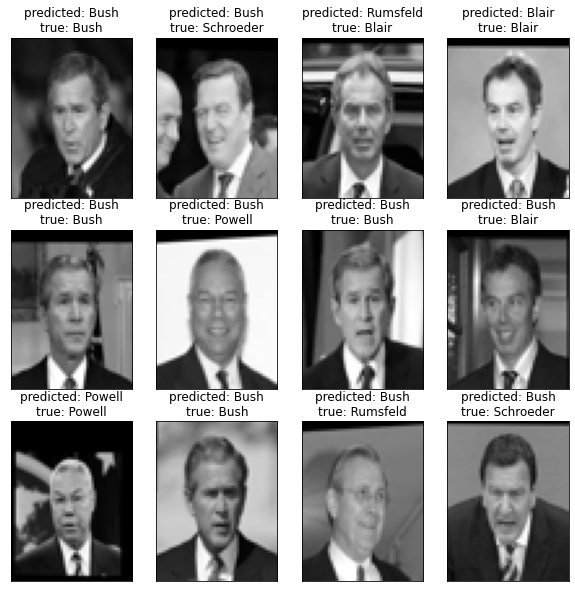

In [62]:
# Your solution here
def visualize(images, titles, h, w, rows=3, cols=4):
    plt.figure(figsize=(10,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

# Define a function to predict and format the prediction results  
def predict(y_pred, y_test, target_names):
    # Iterate over all predicted labels
    for i in range(y_pred.shape[0]):
        # Extract the last name of the predicted and true labels using the target names array
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)

        
print('WITH PCA')        
prediction_titles = list(predict(y_pred_pca, y_test, names))
visualize(X_test, prediction_titles, h, w)

WITHOUT PCA


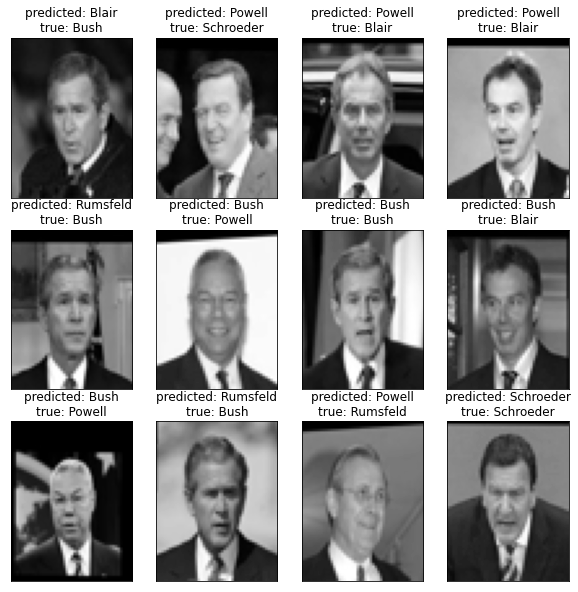

In [63]:
print('WITHOUT PCA')        
prediction_titles = list(predict(y_pred, y_test, names))
visualize(X_test, prediction_titles, h, w)